In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from mplfinance.original_flavor import candlestick_ohlc 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_price_data(ticker='AMZN'):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-10-20')
    return tickerDf.iloc[:, :5]

In [3]:
def plot_candlestick(df, ax=None, fmt="%Y-%m-%d"):
    if ax is None:
        fig, ax = plt.subplots()
    idx_name = df.index.name if df.index.name else 'index'
    dat = df.reset_index()[[idx_name, "Open", "High", "Low", "Close"]]
    dat[idx_name] = dat[idx_name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("OHLC")
    return ax

In [4]:
# get price data (return pandas dataframe)
df = get_price_data()

In [5]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,37.896000,37.938000,37.384998,37.683498,70422000
2017-01-04,37.919498,37.984001,37.709999,37.859001,50210000
2017-01-05,38.077499,39.119999,38.013000,39.022499,116602000
2017-01-06,39.118000,39.972000,38.924000,39.799500,119724000
2017-01-09,39.900002,40.088501,39.588501,39.846001,68922000


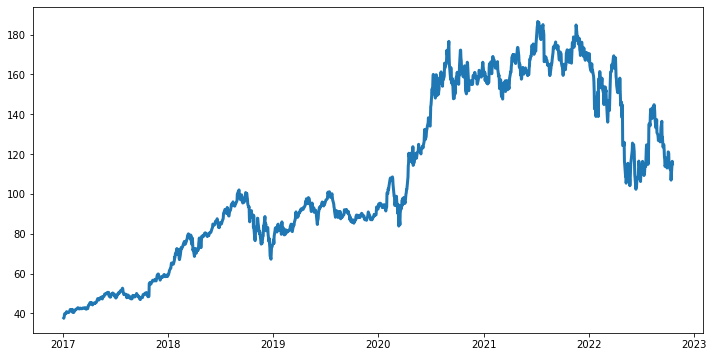

In [25]:

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], linewidth=3.0)
plt.show()

In [7]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import warnings
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
warnings.filterwarnings("ignore")

In [8]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,37.896000,37.938000,37.384998,37.683498,70422000
2017-01-04,37.919498,37.984001,37.709999,37.859001,50210000
2017-01-05,38.077499,39.119999,38.013000,39.022499,116602000
2017-01-06,39.118000,39.972000,38.924000,39.799500,119724000
2017-01-09,39.900002,40.088501,39.588501,39.846001,68922000
...,...,...,...,...,...
2022-10-13,107.879997,113.440002,105.349998,112.529999,86868100
2022-10-14,114.099998,114.959999,106.599998,106.900002,67651200
2022-10-17,110.110001,114.190002,110.089996,113.790001,62782000


In [9]:
df['1stdiff'] = df['Close'].diff()

In [10]:
df['LogClose'] = np.log(df['Close'])

In [16]:
from statsmodels.tsa.arima.model import ARIMA

#df.index.freq =  'M' # Частотность измерения месяц

Ntest = 30
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [17]:
arima = ARIMA(train['Close'], order=(0,1,0))

In [18]:
arima_result = arima.fit()

In [23]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

<AxesSubplot:xlabel='Date'>

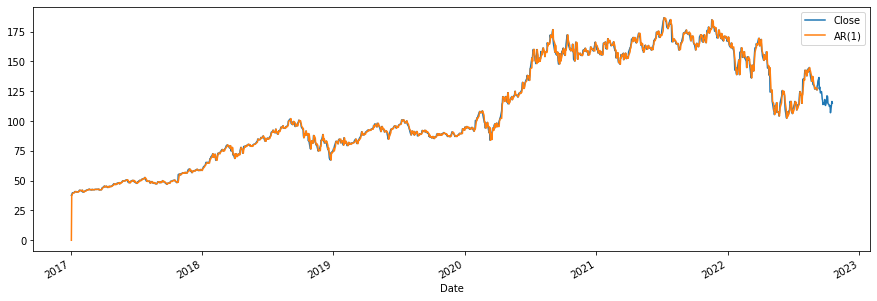

In [24]:
df[['Close', 'AR(1)']].plot(figsize=(15, 5))

In [24]:
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast

<AxesSubplot:xlabel='Date'>

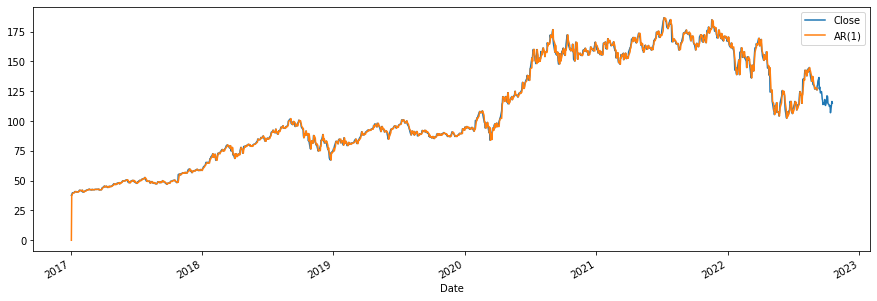

In [25]:
df[['Close', 'AR(1)']].plot(figsize=(15, 5))

In [26]:
type(prediction_result)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [27]:
# Confidencde Intervals
prediction_result.conf_int()

,lower Close,upper Close
1430,124.642830,134.317162
1431,122.639210,136.320781
1432,121.101779,137.858213
1433,119.805664,139.154327
1434,118.663764,140.296227
1435,117.631408,141.328584
1436,116.682058,142.277934
1437,115.798425,143.161567
1438,114.968498,143.991493
1439,114.183534,144.776457


In [28]:
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(df['Close'], label='data')
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')

    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower Close'], conf_int['upper Close']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
    ax.legend()

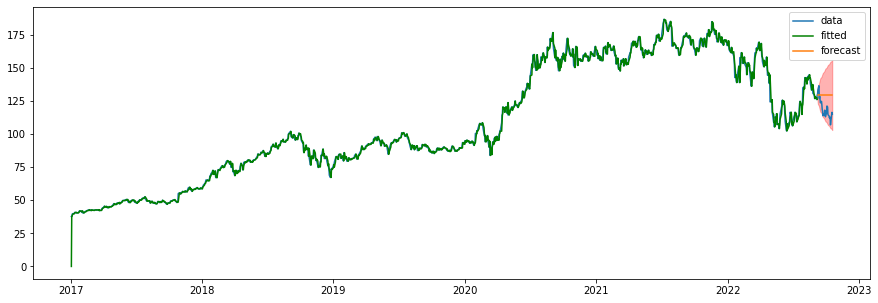

In [29]:
plot_fit_and_forecast(arima_result)

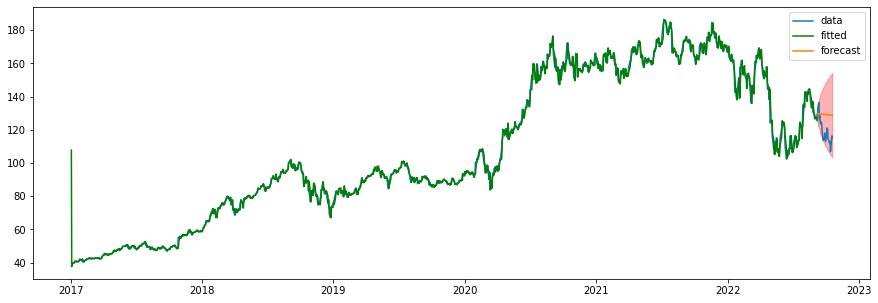

In [39]:
# AR(10)
arima = ARIMA(train['Close'], order=(10,0,0))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

In [40]:
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from tqdm import tqdm_notebook


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [41]:
df.head(30)

,Open,High,Low,Close,Volume,1stdiff,LogClose,AR(1)
Date,,,,,,,,
2017-01-03,37.896000,37.938000,37.384998,37.683498,70422000,NaN,3.629222,0.000000
2017-01-04,37.919498,37.984001,37.709999,37.859001,50210000,0.175503,3.633869,37.683498
2017-01-05,38.077499,39.119999,38.013000,39.022499,116602000,1.163498,3.664138,37.859001
2017-01-06,39.118000,39.972000,38.924000,39.799500,119724000,0.777000,3.683854,39.022499
2017-01-09,39.900002,40.088501,39.588501,39.846001,68922000,0.046501,3.685022,39.799500
2017-01-10,39.830002,39.900002,39.477001,39.794998,51168000,-0.051003,3.683741,39.846001
2017-01-11,39.682999,39.974998,39.475498,39.951000,59856000,0.156002,3.687654,39.794998
2017-01-12,40.015499,40.706501,39.974998,40.681999,97478000,0.730999,3.705786,39.951000
2017-01-13,40.716000,41.082500,40.570000,40.856998,75838000,0.174999,3.710078,40.681999


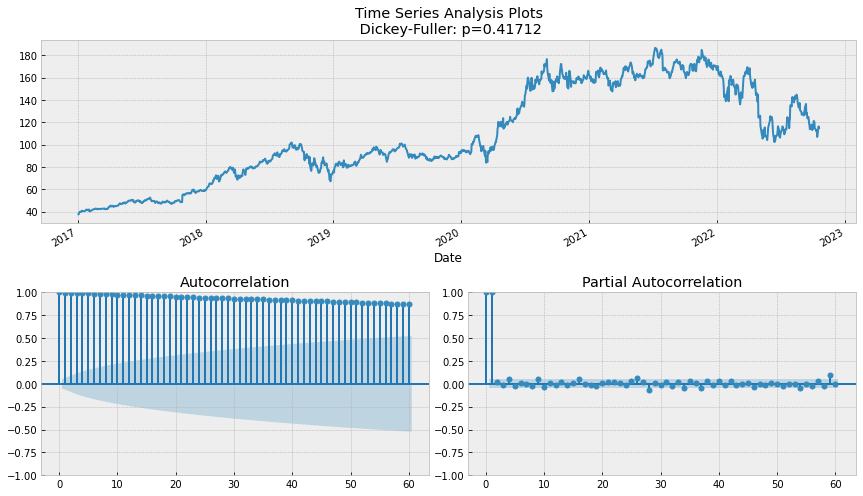

In [42]:
tsplot(df.Close, lags=60)

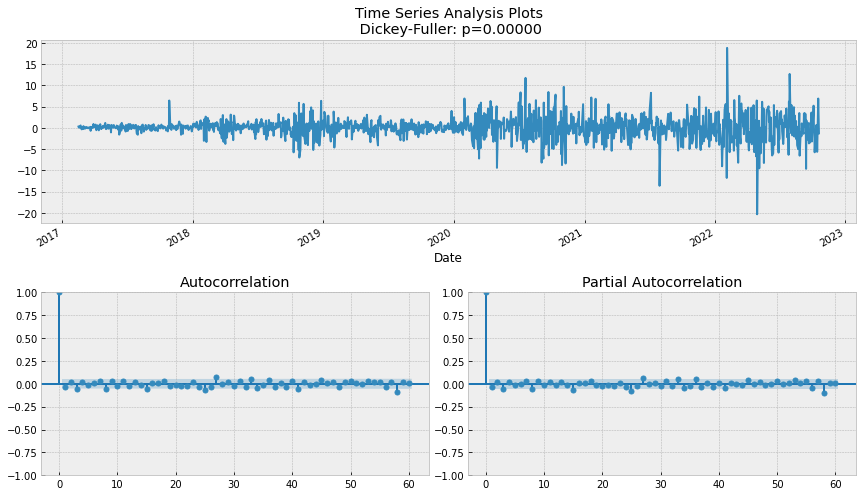

In [43]:
df_diff = df.Close - df.Close.shift(1)
tsplot(df_diff[30:], lags=60)

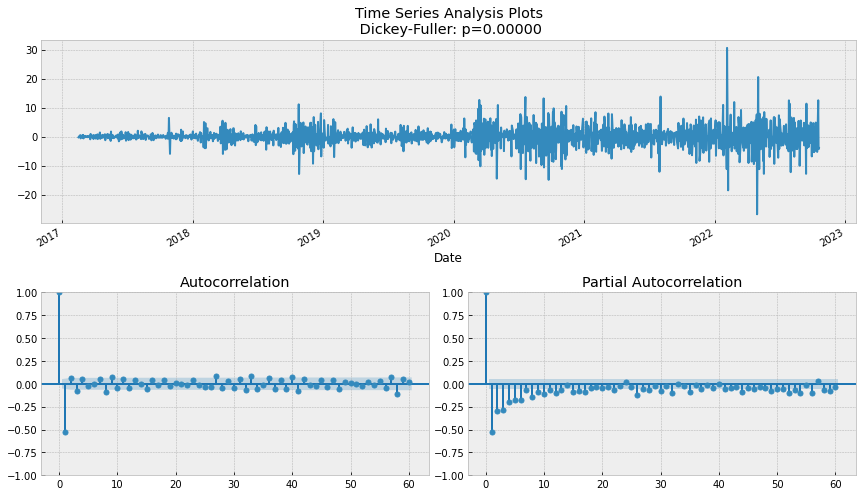

In [44]:
df_diff = df_diff - df_diff.shift(1)
tsplot(df_diff[30+1:], lags=60)

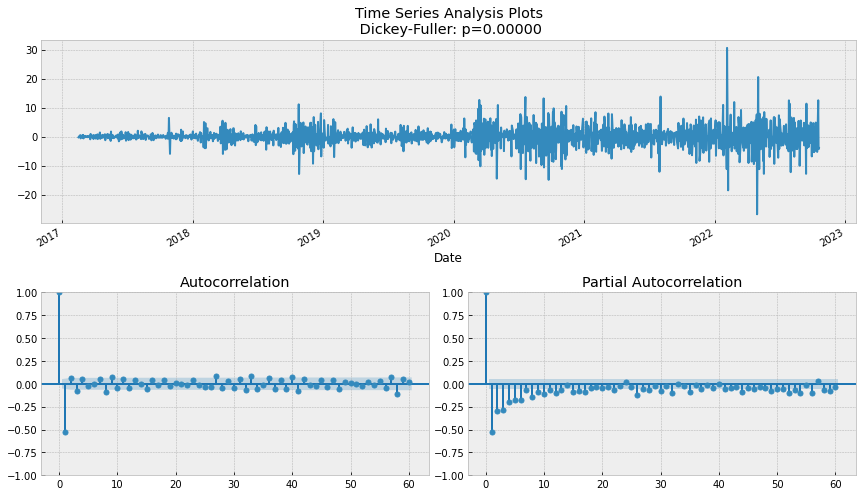

In [45]:
tsplot(df_diff[30+1:], lags=60)

In [46]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1
qs = range(2, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [47]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df.Close, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [48]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 40min 47s, sys: 4.97 s, total: 40min 52s
Wall time: 10min 36s


In [49]:
result_table.head()

,parameters,aic
0,"(2, 2, 0, 1)",6784.991711
1,"(2, 2, 1, 1)",6785.564960
2,"(2, 3, 0, 1)",6786.458210
3,"(3, 2, 0, 1)",6786.469361
4,"(2, 3, 1, 1)",6787.238649


In [50]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df.Close, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                 1460
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 24)   Log Likelihood               -3386.496
Date:                              Wed, 26 Oct 2022   AIC                           6784.992
Time:                                      03:03:38   BIC                           6816.605
Sample:                                           0   HQIC                          6796.795
                                             - 1460                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6927      0.016   -103.390      0.000      -1.725      -1.661
ar.L2         -0.94

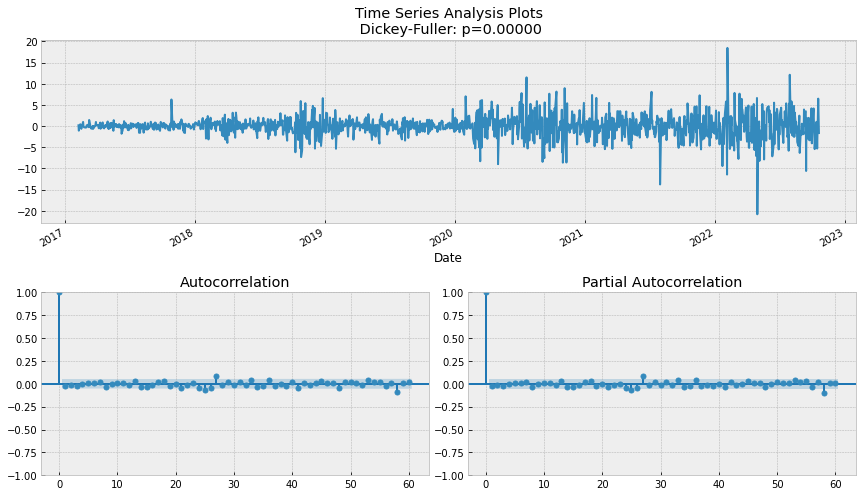

In [51]:
tsplot(best_model.resid[24+1:], lags=60)

In [52]:
# def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
#     """
#         Plots model vs predicted values

#         series - dataset with timeseries
#         model - fitted SARIMA model
#         n_steps - number of steps to predict in the future

#     """
#     # adding model values
#     data = series.copy()
#     data.columns = ['actual']
#     data['arima_model'] = model.fittedvalues
#     # making a shift on s+d steps, because these values were unobserved by the model
#     # due to the differentiating
#     data['arima_model'][:s+d] = np.NaN

#     # forecasting on n_steps forward
#     forecast = best_model.get_forecast(steps=365)
#     model_predictions = data.arima_model.append(forecast.predicted_mean)
#     # calculate error, again having shifted on s+d steps from the beginning
#     error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])


#     plt.figure(figsize=(15, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

#     plt.plot(model_predictions, color='r', label="model")
#     plt.plot(data.actual, label="actual")

#     if plot_intervals:
#         intervals = forecast.conf_int(alpha=alpha)
#         intervals.columns=['lower', 'upper']
#         plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
#         plt.plot(intervals['upper'], "r--", alpha=0.5)
#         plt.fill_between(x=intervals.index, y1=intervals['upper'],
#                          y2=intervals['lower'], alpha=0.2, color = "grey")


#     plt.legend()
#     plt.grid(True);
    
def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    # forecasting on n_steps forward 
    forecast = best_model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);
 



# def plotSARIMA(series, model, n_steps):
#     """
#         Plots model vs predicted values
        
#         series - dataset with timeseries
#         model - fitted SARIMA model
#         n_steps - number of steps to predict in the future
        
#     """
#     # adding model values
#     data = series.copy()
#     data.columns = ['actual']
#     data['arima_model'] = model.fittedvalues
#     # making a shift on s+d steps, because these values were unobserved by the model
#     # due to the differentiating
#     data['arima_model'][:s+d] = np.NaN
    
#     # forecasting on n_steps forward 
#     forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
#     forecast = data.arima_model.append(forecast)
#     # calculate error, again having shifted on s+d steps from the beginning
#     error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

#     plt.figure(figsize=(15, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
#     plt.plot(forecast, color='r', label="model")
#     plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
#     plt.plot(data.actual, label="actual")
#     plt.legend()
#     plt.grid(True);



In [53]:
mask = ['Close']

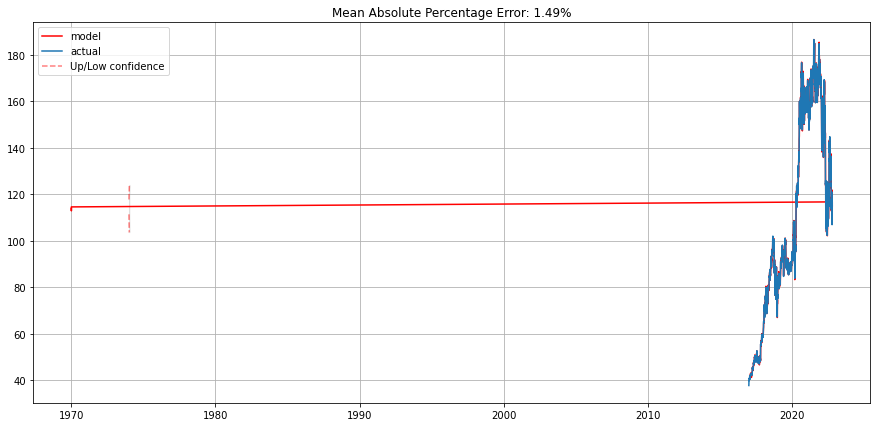

In [54]:
plotSARIMA(df[mask], best_model, 10)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from mplfinance.original_flavor import candlestick_ohlc 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from prophet import Prophet

In [3]:
def get_price_data(ticker='AMZN'):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-10-20')
    return tickerDf.iloc[:, :5]

In [4]:
def plot_candlestick(df, ax=None, fmt="%Y-%m-%d"):
    if ax is None:
        fig, ax = plt.subplots()
    idx_name = df.index.name if df.index.name else 'index'
    dat = df.reset_index()[[idx_name, "Open", "High", "Low", "Close"]]
    dat[idx_name] = dat[idx_name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("OHLC")
    return ax

In [5]:
df = get_price_data()

In [6]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,37.896000,37.938000,37.384998,37.683498,70422000
2017-01-04,37.919498,37.984001,37.709999,37.859001,50210000
2017-01-05,38.077499,39.119999,38.013000,39.022499,116602000
2017-01-06,39.118000,39.972000,38.924000,39.799500,119724000
2017-01-09,39.900002,40.088501,39.588501,39.846001,68922000
...,...,...,...,...,...
2022-10-13,107.879997,113.440002,105.349998,112.529999,86868100
2022-10-14,114.099998,114.959999,106.599998,106.900002,67651200
2022-10-17,110.110001,114.190002,110.089996,113.790001,62782000


In [7]:
import pandas as pd 
df = df.drop(columns=['Open', 'High', 'Low', 'Volume']) #, axis='columns')



 
# student_dict = {"name": ["John", "Alex"], "age": [24, 18], "marks": [77.29, 69.15]} 
 
    
# student_df = pd.DataFrame(student_dict) 
# print(student_df.columns.values) 
 
# # drop 2 columns at a time 
# student_df = student_df.drop(columns=['age', 'marks']) 
 
# print(student_df.columns.values) 
# Источник: https://pythonpip.ru/pandas/kak-udalit-stolbtsy-v-pandas
df

,Close
Date,
2017-01-03,37.683498
2017-01-04,37.859001
2017-01-05,39.022499
2017-01-06,39.799500
2017-01-09,39.846001
...,...
2022-10-13,112.529999
2022-10-14,106.900002
2022-10-17,113.790001


In [8]:
# number of future predictions
predictions = 60

# creating a specific format dataset 
df = df.reset_index()

df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['ds', 'y']


In [9]:
df

,ds,y
0,2017-01-03,37.683498
1,2017-01-04,37.859001
2,2017-01-05,39.022499
3,2017-01-06,39.799500
4,2017-01-09,39.846001
...,...,...
1455,2022-10-13,112.529999
1456,2022-10-14,106.900002
1457,2022-10-17,113.790001
1458,2022-10-18,116.360001


In [10]:
# Инициализируем модель и обучим ее
model = Prophet()
model.fit(df)

08:15:44 - cmdstanpy - INFO - Chain [1] start processing
08:15:45 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

In [12]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-03,40.962485,32.623623,51.892227,40.962485,40.962485,0.622877,0.622877,0.622877,0.792678,0.792678,0.792678,-0.169801,-0.169801,-0.169801,0.0,0.0,0.0,41.585362
1,2017-01-04,40.997713,32.764371,51.288411,40.997713,40.997713,0.666123,0.666123,0.666123,0.887303,0.887303,0.887303,-0.221179,-0.221179,-0.221179,0.0,0.0,0.0,41.663836
2,2017-01-05,41.032941,32.163132,50.155960,41.032941,41.032941,0.477122,0.477122,0.477122,0.779554,0.779554,0.779554,-0.302432,-0.302432,-0.302432,0.0,0.0,0.0,41.510063
3,2017-01-06,41.068168,32.214720,51.515826,41.068168,41.068168,0.032910,0.032910,0.032910,0.445401,0.445401,0.445401,-0.412492,-0.412492,-0.412492,0.0,0.0,0.0,41.101078
4,2017-01-09,41.173852,30.090829,50.529623,41.173852,41.173852,-0.299255,-0.299255,-0.299255,0.592535,0.592535,0.592535,-0.891790,-0.891790,-0.891790,0.0,0.0,0.0,40.874597


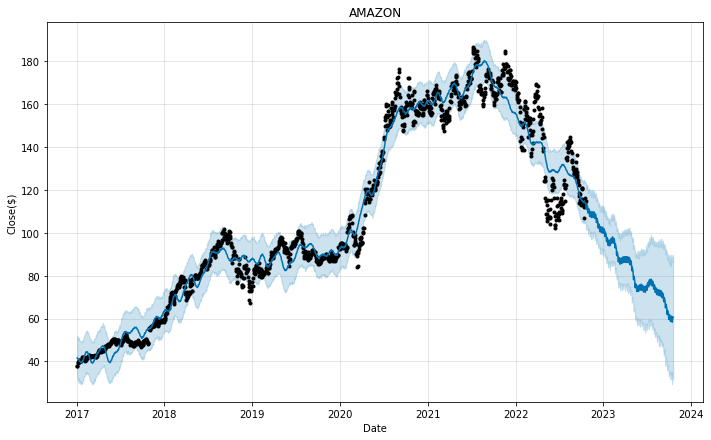

In [13]:
fig = model.plot(forecast, xlabel='Date',
                 ylabel=r'Close($)')
plt.title('AMAZON')
plt.show()

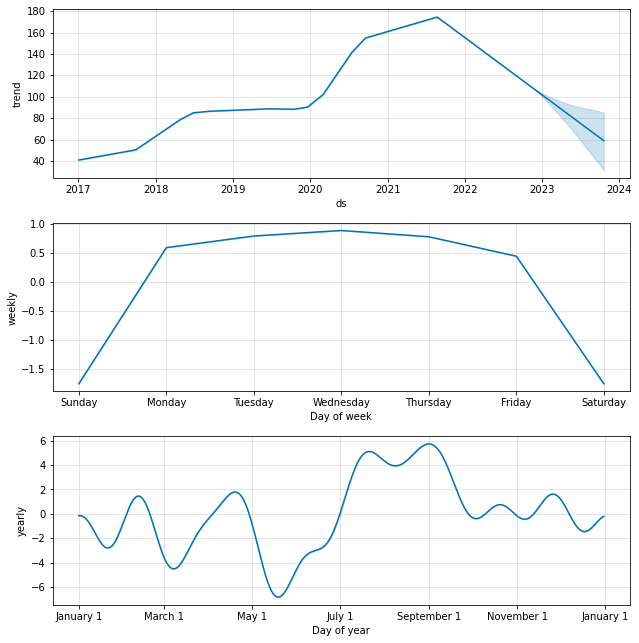

In [14]:
fig2 = model.plot_components(forecast)
plt.show()

Для фондовых рынков библиотека Facebook Prophet дает сомнительный результат.